In [63]:
pip install lightfm

In [64]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import preprocessing
from lightfm import LightFM
from scipy.sparse import csr_matrix 
from scipy.sparse import coo_matrix 
from sklearn.metrics import roc_auc_score
import time
from lightfm.evaluation import auc_score
import pickle
import re
import seaborn as sns

In [91]:
courses = pd.read_csv('course.csv',encoding='gbk')
users = pd.read_csv('user.csv')
ratings = pd.read_csv('rating.csv')

In [92]:
ratings_explicit = ratings[ratings.courseid.isin(courses.courseid)]
ratings_explicit.shape

(576, 3)

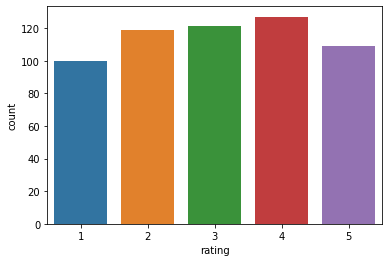

In [93]:
sns.countplot(data=ratings_explicit , x='rating')
plt.show()

In [94]:
def informed_train_test(rating_df, train_ratio):
    split_cut = np.int(np.round(rating_df.shape[0] * train_ratio))
    train_df = rating_df.iloc[0:split_cut]
    test_df = rating_df.iloc[split_cut::]
    test_df = test_df[(test_df['userid'].isin(train_df['userid'])) & (test_df['courseid'].isin(train_df['courseid']))]
    id_cols = ['userid', 'courseid']
    trans_cat_train = dict()
    trans_cat_test = dict()
    for k in id_cols:
        cate_enc = preprocessing.LabelEncoder()
        trans_cat_train[k] = cate_enc.fit_transform(train_df[k].values)
        trans_cat_test[k] = cate_enc.transform(test_df[k].values)

    cate_enc = preprocessing.LabelEncoder()
    ratings = dict()
    ratings['train'] = cate_enc.fit_transform(train_df.rating)
    ratings['test'] = cate_enc.transform(test_df.rating)

    n_users = len(np.unique(trans_cat_train['userid']))
    n_items = len(np.unique(trans_cat_train['courseid']))


    train = coo_matrix((ratings['train'], (trans_cat_train['userid'],trans_cat_train['courseid'])),shape=(n_users, n_items))
    test = coo_matrix((ratings['test'], (trans_cat_test['userid'],trans_cat_test['courseid'])), shape=(n_users, n_items))
    return train, test, train_df

In [95]:
train, test, raw_train_df = informed_train_test(ratings, .8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [107]:
start_time = time.time()
model=LightFM(no_components=115,learning_rate=0.15,loss='warp')
model.fit(train,epochs=25,num_threads=4)
auc_train = auc_score(model, train).mean()
auc_test = auc_score(model, test).mean()
print('AUC: train %.2f, test %.2f.' % (auc_train, auc_test))

from lightfm.evaluation import precision_at_k
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))



AUC: train 0.97, test 0.42.
Precision: train 0.46, test 0.10.


In [118]:
model = LightFM(learning_rate=0.15, loss='bpr')
model.fit(train, epochs=25)
with open('saved_model','wb') as f:
     saved_model={'model':model}
     pickle.dump(saved_model, f)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.46, test 0.09.
AUC: train 0.96, test 0.53.


In [119]:
user_item_matrix = raw_train_df.pivot(index='userid', columns='courseid', values='rating')
user_item_matrix.fillna(0, inplace = True)
user_item_matrix = user_item_matrix.astype(np.int32)
print(user_item_matrix.shape)
user_item_matrix.head()

(99, 19)


courseid,BINF6111,BINF9010,COMP4141,COMP6441,COMP6841,COMP9020,COMP9021,COMP9024,COMP9041,COMP9101,COMP9154,COMP9311,COMP9313,COMP9315,COMP9319,COMP9331,COMP9415,COMP9417,COMP9517
userid,,,,,,,,,,,,,,,,,,,
5190114,0,0,0,0,0,4,1,0,0,0,0,1,4,0,3,0,0,0,0
5190239,3,0,0,2,0,4,4,0,0,0,5,3,0,0,0,0,0,0,0
5190259,2,0,4,0,0,1,5,0,0,0,0,3,0,0,0,0,0,0,0
5190455,0,0,0,0,0,2,3,0,0,0,0,1,0,0,0,1,0,0,0
5190468,0,0,0,0,0,4,2,0,4,0,0,1,0,0,0,0,0,0,0


In [120]:
def user_item_dikts(interaction_matrix, items_df):
    user_ids = list(interaction_matrix.index)
    user_dikt = {}
    counter = 0 
    for i in user_ids:
        user_dikt[i] = counter
        counter += 1

    item_dikt ={}
    for i in range(items_df.shape[0]):
        item_dikt[(items_df.loc[i,'courseid'])] = items_df.loc[i,'courseid']
    
    return user_dikt, item_dikt

In [128]:
#Function to produce the user recommendations
def similar_recommendation(model, interaction_matrix, user_id, user_dikt, 
                               item_dikt,threshold = 0,number_rec_items = 15):
    n_users, n_items = interaction_matrix.shape
    user_x = user_dikt[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interaction_matrix.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interaction_matrix.loc[user_id,:][interaction_matrix.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    score_list = scores[0:number_rec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dikt[x]))
    scores = list(pd.Series(score_list).apply(lambda x: item_dikt[x]))

    print("Items that were liked by the User:")
    counter = 1
    for i in known_items[:25]:
        print(str(counter) + '- ' + i)
        counter+=1

    print("\n Recommended Items:")
    counter = 1
    for i in scores:
        print(str(counter) + '- ' + i)
        counter+=1

In [129]:
#Funnction to produce a list of top N interested users for a given item
def users_for_item(model,interaction_matrix,courseid,number_of_user):
    n_users, n_items = interaction_matrix.shape
    x = np.array(interaction_matrix.columns)
    scores = pd.Series(model.predict(np.arange(n_users), np.repeat(x.searchsorted(courseid),n_users)))
    user_list = list(interaction_matrix.index[scores.sort_values(ascending=False).head(number_of_user).index])
    return user_list

In [130]:
from sklearn.metrics.pairwise import cosine_similarity
def item_emdedding_distance_matrix(model,interaction_matrix):
    df_item_norm_sparse = csr_matrix(model.item_embeddings)
    similarities = cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = interaction_matrix.columns
    item_emdedding_distance_matrix.index = interaction_matrix.columns
    return item_emdedding_distance_matrix

def also_enrolled_recommendation(item_emdedding_distance_matrix, item_id, 
                             item_dikt, n_items = 4):
    recommended_items = list(pd.Series(item_emdedding_distance_matrix.loc[item_id,:].sort_values(ascending = False).head(n_items+1).index[1:n_items+1]))
    
    print("Item of interest :{}".format(item_dikt[item_id]))
    print("Items that are frequently enrolled together:")
    counter = 1
    for i in recommended_items:
        print(str(counter) + '- ' +  item_dikt[i])
        counter+=1
    return recommended_items


In [131]:
user_dikt, item_dikt = user_item_dikts(user_item_matrix, courses)

In [132]:
similar_recommendation(model, user_item_matrix, 5190114, user_dikt, item_dikt,threshold = 7)

Items that were liked by the User:

 Recommended Items:
1- COMP9311
2- COMP9020
3- COMP9021
4- COMP9319
5- COMP9313
6- COMP9101
7- COMP6841
8- COMP9315
9- COMP6441
10- BINF6111
11- COMP9517
12- COMP9024
13- BINF9010
14- COMP9417
15- COMP9154


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [133]:
item_embedings = item_emdedding_distance_matrix(model,user_item_matrix)
also_enrolled_recommendation(item_embedings,'BINF6111' ,item_dikt)

Item of interest :BINF6111
Items that are frequently enrolled together:
1- COMP9101
2- COMP4141
3- COMP9311
4- COMP9024


['COMP9101', 'COMP4141', 'COMP9311', 'COMP9024']